# `musterloeser`: A basic branch-and-bound algorithm for testing and visualization purposes

In [1]:
import random
import numpy as np
import pyomo.environ as pyo

import logging

logger = logging.getLogger("main")

logger.setLevel(logging.INFO)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
logger.addHandler(ch)


from musterloeser import branch_and_bound

## Example problem: 0-1 knapsack problem

In [2]:
def pyomo_create_model() -> pyo.AbstractModel:

    model = pyo.AbstractModel("0-1 Knapsack Problem")

    model.SetItems = pyo.Set()
    model.value = pyo.Param(model.SetItems, within=pyo.NonNegativeReals)
    model.weight = pyo.Param(model.SetItems, within=pyo.NonNegativeReals)

    model.weight_capacity = pyo.Param(within=pyo.NonNegativeReals)

    model.is_picked = pyo.Var(model.SetItems, within=pyo.Binary)

    @model.Constraint(doc="maximum capacity")
    def total_weight_constr(model):
        return (
            sum(model.weight[i] * model.is_picked[i] for i in model.SetItems)
            <= model.weight_capacity
        )

    @model.Objective(sense=pyo.maximize, doc="total value")
    def total_value(model):
        return sum(model.value[i] * model.is_picked[i] for i in model.SetItems)

    return model

### Random parameters

In [3]:
num_items = 5
data = {
    None: {
        "SetItems": {None: range(num_items - 1)},
        "value": {i: random.random() for i in range(num_items - 1)},
        "weight": {i: random.random() for i in range(num_items - 1)},
    }
}
data[None]["weight_capacity"] = {None: 1}

In [4]:
model = pyomo_create_model()
instance = model.create_instance(data)

### Solve it with `musterloeser`

In [5]:
%%time
g = branch_and_bound(instance, lp_solver="glpk")

variable selection rule is 'max fractional rule'
branching rule is 'LIFO'


okay let's go!
solved root problem: 1.11810707972829

node | incumbent |      dual |  gap
   0 |       nan |      1.12 |  nan
   1 |       nan |      1.06 |  nan
   2 |       nan |      1.08 |  nan
   3 |       nan |      1.06 |  nan
   4 |       nan |      1.06 |  nan
   5 |       nan |      1.06 |  nan
   6 |       nan |      1.06 |  nan
   7 |      0.80 |      1.06 | 0.33
   8 |      0.80 |      1.06 | 0.33
   9 |      0.99 |      0.99 | 0.00
  10 |      0.99 |      1.02 | 0.03
  11 |      0.99 |      0.99 | 0.00
  12 |      0.99 |      0.99 | 0.00
solved!
primal: 0.99309213977452
dual: 0.99309213977452
CPU times: user 24.9 ms, sys: 45.6 ms, total: 70.5 ms
Wall time: 97.9 ms


### Verify results

In [6]:
instance = model.create_instance(data)

In [7]:
%%time
with pyo.SolverFactory("glpk", solver_io="lp") as opt:
    results = opt.solve(instance, tee=False)

print("primal = {}".format(results.problem.upper_bound))
print("dual = {}".format(results.problem.lower_bound))

primal = 0.99309213977452
dual = 0.99309213977452
CPU times: user 1.77 ms, sys: 3.61 ms, total: 5.38 ms
Wall time: 7.21 ms


## Visualization

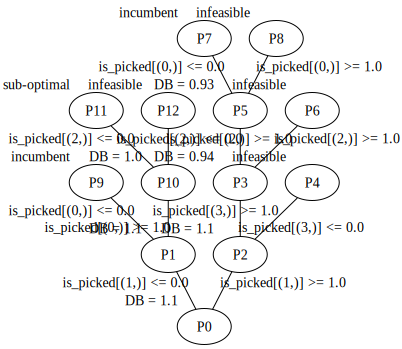

In [8]:
import graphviz

fname = "graph.dot"
g.write(fname, format="dot")

dot = graphviz.Source.from_file(fname)
dot

In [9]:
!dot -Tpdf -o out.pdf graph.dot